  

## <center>CSCI-UA 9473 Introduction to Machine Learning</center>
### <center>Fall 2021</center>
## <center>Assignment 3: Convolutional nets, SVM and Robust PCA</center>


<center><font color='red'><b>Given date: Thursday November 1</b></font></center>

<center><font color='red'><b>Due date: Friday November 26 </b></font></center>


#### <center>Total: 30pts</center>

Additional readings (To go further): 

 - [Ian Goodfellow and Yoshua Bengio and Aaron Courville, Deep Learning](https://www.deeplearningbook.org/)
 - [Robust principal component analysis? EJ Candès, X Li, Y Ma, J Wright ](https://arxiv.org/pdf/0912.3599.pdf)
 - [Saharon Rosset, Ji Zhu and Trevor Hastie, Margin Maximizing Loss Functions](https://web.stanford.edu/~hastie/Papers/margmax1.pdf)
 
The assignment is divided into three parts. In the first part, we will go back to neural networks. You will be asked to build and train a convolutional neural network for image classification. In the second part, we will focus on the max margin classifier and study how such a classifier can be learned by means of gradient descent. Finally, in the last part, we will implement a principal component decomposition of a video sequence to extract moving targets from their background. 

## Question I: (10pts) conv nets and autonomous driving 


In this first question, we will use [the Keras API](https://keras.io/) to build and train a convolutional neural network to discriminate between four types of road signs. To simplify we will consider the detection of 4 different signs: 

- A '30 km/h' sign (folder 1)
- A 'Stop' sign 
- A 'Go straight' sign
- A 'Keep left' sign 


<img src="learning2Drive.jpeg" style="width:400px">


An example of each sign is given below.

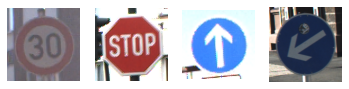

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img1 = mpimg.imread('1/00001_00000_00012.png')
plt.subplot(141)
plt.imshow(img1)
plt.axis('off')
plt.subplot(142)
img2 = mpimg.imread('2/00014_00001_00019.png')
plt.imshow(img2)
plt.axis('off')
plt.subplot(143)
img3 = mpimg.imread('3/00035_00008_00023.png')
plt.imshow(img3)
plt.axis('off')
plt.subplot(144)
img4 = mpimg.imread('4/00039_00000_00029.png')
plt.imshow(img4)
plt.axis('off')
plt.show()

### Question I.1. (10pts) 

In this exercise, you need to build and train a convolutional neural network to discriminate between the four images.  

- Before building the network, you should start by cropping the images so that they all have a common predefined size (take the smallest size across all images) 

- We will use a __Sequential model__ from Keras but it will be up to you to define the structure of the convolution net. Initialization of the sequential model can be done with the following line 

In [2]:
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob

# reading data
image_size = (100, 100)
img_list = []
target_list = []
for folder in range(1, 5):
    folder_name = str(folder)
    for img in glob.glob(folder_name + "/*.png"):
        img_temp = cv2.imread(img)
        img_temp = cv2.resize(img_temp, image_size)
        img_list.append(img_temp)
        target_list.append(folder)


def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

img_list = np.asarray(img_list)
target_list = np.asarray(target_list).reshape(-1, 1)
img_list, target_list = unison_shuffled_copies(img_list, target_list)

train_image = np.asarray(img_list[:3500])
train_labels = np.asarray(target_list[:3500]).reshape(-1, 1)

test_image = np.asarray(img_list[3500:])
test_labels = np.asarray(target_list[3500:]).reshape(-1, 1)

model = Sequential()


2021-11-23 20:31:23.053880: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### I.1.a. Convolutions. 

- We will use a __convolutional__ architecture. you can add convolutional layers to the model by using the following lines 

In [3]:
model.add(Conv2D(16, (3, 3), padding='same', input_shape=(image_size[0], image_size[1], 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2), strides=None))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))

for the first layer and                     

In [4]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        4640      
                                                                 
Total params: 5,088
Trainable params: 5,088
Non-trainable params: 0
_________________________________________________________________
None


for all the others. 'filters' indicate the number of filters you want to use in the convolutional layer. filter_size is the size of each filter and activation is the usual activation that comes on top of the convolution, i.e.
$x_{\text{out}} = \sigma(\text{filter}*\text{input})$. Finally input_shape indicates the size of your input. Note that only the input layer should be given the input size. Subsequent layers will automatically compute the size of their inputs based on previous layers. 

#### I.1.b Pooling Layers 

On top of the convolutional layers, convolutional neural networks (CNN) also often rely on __Pooling layers__. The addition of such a  layer can be done through the following line 

  
The _pooling layers_ usually come with two parameters: the 'pool size' and the 'stride' parameter. The basic choice for the pool size is (2,2) and the stride is usually set to None (which means it will split the image into non overlapping regions such as in the Figure below). You should however feel free to play a little with those parameters. The __MaxPool operator__ considers a mask of size 'pool_size' which is slided over the image by a number of pixels equal to the stride parameters (in x and y, there are hence two translation parameters). for each position of the mask, the output only retains the max of the pixels appearing in the mask (This idea is illustrated below). One way to understand the effect of the pooling operator is that if the filter detects an edge in a subregion of the image (thus returning at least one large value), although a MaxPooling will reduce the number of parameters, it will keep track of this information.    

Adding 'Maxpooling' layers is known to work well in practice. 

<img src="Maxpool.png" style="width:500px">


Although it is a little bit up to you to decide how you want to structure the network, a good start is to add a couple (definitely not exceeding 4) combinations (convolution, convolution, Pooling) with increasing number of units (you do every power of two like 16, 32, 128,...). 

#### I.1.c. Flattening and Fully connected layers

Once you have stacked the convolutional and pooling layers, you should flatten the output through a line of the form

And add a couple (no need to put more than 2,3) dense fully connected layers through lines of the form

In [5]:
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(5, activation="softmax"))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        4640      
                                                                 
 flatten (Flatten)           (None, 73728)             0         
                                                                 
 dense (Dense)               (None, 10)                737290    
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                        

#### I.1.d. Concluding 

Since there are four possible signs, you need to __finish your network with a dense layer with 4 units__. Each of those units should output four number between 0 and 1 representing the likelihood that any of the four signs is detected and such that $p_1 + p_2 + p_3 + p_4 = 1$ (hopefully with one probability much larger than the others). For this reason, a good choice for the __final activation function__ of those four units is the __softmax__ (Why?). 


Build your model below. 

### Question I.2 (3pts). Setting up the optimizer

Once you have found a good architecture for your network, split the dataset, by retaining about 90% of the images for training and 10% of each folder for test. To train your network in Keras, we need two more steps. The first step is to set up the optimizer. Here again it is a little bit up to you to decide how you want to set up the optimization. Two popular approaches are __SGD and ADAM__. You will get to choose the learning rate. This rate should however be between 1e-3 and 1e-2. Once you have set up the optimizer, we need to set up the optimization parameters. This includes the loss (we will take it to be the __categorical cross entropy__ which is the extension of the log loss to the multiclass problem).   

In [6]:
# from tensorflow.keras.optimizers import SGD
# from tensorflow.keras.optimizers import Adam

# set up the optimize here
# Myoptimizer = SGD
# Myoptimizer = Adam

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer="adam",
              metrics=['accuracy'])

### Question I.3 (2pts). Optimization

The last step is to fit the network to your data. Just as any function in scikit-learn, we use a call to the function 'fit'. The training of neural networks can be done by splitting the dataset into minibatches and using a different batch at each SGD step. This process is repeated over the whole dataset. A complete screening of the dataset is called an epoch. We can then repeat this idea several times. In keras the number of epochs is stored in the 'epochs' parameter and the batch size is stored in the 'batch_size' parameter.   

In [7]:
batch_size = 32
epochs = 15

history = model.fit(train_image, train_labels, batch_size=batch_size, epochs=epochs, validation_data=(test_image, test_labels))


Epoch 1/15
110/110 [==============================] - 9s 78ms/step - loss: 14.9578 - accuracy: 0.8597 - val_loss: 0.0234 - val_accuracy: 0.9900
Epoch 2/15
110/110 [==============================] - 8s 73ms/step - loss: 0.0203 - accuracy: 0.9911 - val_loss: 0.0144 - val_accuracy: 0.9950
Epoch 3/15
110/110 [==============================] - 8s 75ms/step - loss: 0.0068 - accuracy: 0.9983 - val_loss: 0.0229 - val_accuracy: 0.9970
Epoch 4/15
110/110 [==============================] - 8s 74ms/step - loss: 0.0042 - accuracy: 0.9997 - val_loss: 0.0080 - val_accuracy: 0.9980
Epoch 5/15
110/110 [==============================] - 8s 75ms/step - loss: 0.0443 - accuracy: 0.9911 - val_loss: 0.0138 - val_accuracy: 0.9940
Epoch 6/15
110/110 [==============================] - 8s 76ms/step - loss: 0.0100 - accuracy: 0.9983 - val_loss: 0.0230 - val_accuracy: 0.9950
Epoch 7/15
110/110 [==============================] - 8s 75ms/step - loss: 0.0050 - accuracy: 0.9991 - val_loss: 0.0156 - val_accuracy: 0.997

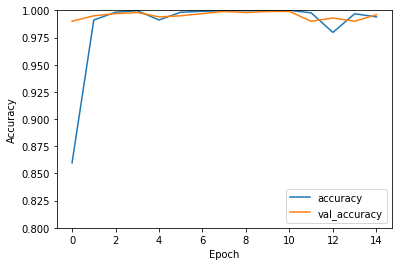

In [17]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1])
plt.legend(loc='lower right')

plt.show()

## Question II (10pts): Max margin classifiers and outliers

Consider the dataset below. We would like to learn a classifier for this dataset that maximizes the margin (i.e. such that the distance between the closest points to the classifier is maximized). We have seen that one can solve this problem by means of the constrained formulation

\begin{align*}
\min_{\mathbf{\beta}} \quad & \|\mathbf{\beta}\|^2 \\
\text{subject to} \quad & y(\mathbf{x}^{(i)})t^{(i)} \geq 1 
\end{align*}

where $y(\mathbf{x}^{(i)}) = \mathbf{\beta}^T\mathbf{x}^{(i)} + \beta_0$. We might sometimes want to use a (softer) unconstrained formulation. in particular, when selecting this option, we can use the following function known as the _Hinge loss_ 

\begin{align*}
\max(0, 1-t^{(i)}y(\mathbf{x}^{(i)})) = \max(0, 1-t^{(i)}(\mathbf{\beta}^T\mathbf{x}^{(i)}+\beta_0))
\end{align*}

For such a loss, we can derive a softer, unconstrained version of the problem as 

\begin{align*}
\min_{\mathbf{\beta}} \quad & \|\mathbf{\beta}\|^2 + \frac{C}{N}\sum_{i=1}^N \max(0, 1-t^{(i)}(\mathbf{\beta}^T\mathbf{x}^{(i)}+\beta_0))
\end{align*}

In short we penalize a point, only if this point lies on the wrong side of the plane.

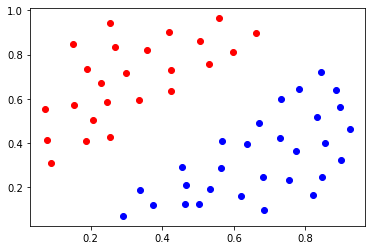

In [9]:
import numpy as np

import matplotlib.pyplot as plt

from scipy.io import loadmat

pointsClass1 = loadmat('KernelPointsEx4class1.mat')['PointsEx4class1']
pointsClass2 = loadmat('KernelPointsEx4class2.mat')['PointsEx4class2']


plt.scatter(pointsClass1[:,0], pointsClass1[:,1], c='r')
plt.scatter(pointsClass2[:,0], pointsClass2[:,1], c='b')
plt.show()

### Question II.1 (3pts)

Start by completing the function below which should return the value and gradient of the hinge loss at a point $\mathbf{x}^{(i)}$. What is the gradient of the hinge loss?

In [10]:
def HingeLoss(x, beta_vec, beta_0):
    
    '''Returns the value and gradient of the hinge 
    loss at the point x'''
    
    value = None
    gradient = None

    t_i = x[-1]
    x_i = np.asarray((x[:-1]))

    # first compute the hinge loss
    value = max(0, 1 - t_i * (np.matmul(beta_vec, x_i.reshape(-1, 1)) + beta_0))
    if isinstance(value, np.ndarray):
        value = value[0]

    # compute the gradient
    if value == 0:
        # in this case, the gradient does not exist
        return value, gradient
    gradient = -t_i * x[0:2]
    
    return value, gradient

### Question II.2 (7pts)

Once you have the function, implement a function HingeLossSVC that takes as innput a starting weight vector $\mathbf{\beta}$ and intercept $\beta_0$ as well as the set of training points and a value for the parameter $C$ and returns the maximum margin classifier.  

In [11]:
def HingeLossSVC(beta_init, beta0_init, training):
    
    '''Returns the maximal margin classifier for the 
    training dataset'''
    
    num_iter = 1000
    eta = 0.05
    C = 0.075
    num_sample = training.shape[0]
    beta = beta_init
    beta0 = beta0_init

    for _ in range(num_iter):
        gradient_temp = np.zeros((beta.shape[0], ))
        beta0_gradient = 0

        for i in range(num_sample):
            hinge_loss_step, gradient_step = HingeLoss(training[i], beta, beta0)
            if hinge_loss_step != 0:
                beta0_gradient += -training[i][-1]
                gradient_temp += gradient_step

        gradient_temp *= C/num_sample
        gradient_temp += 2 * beta
        beta0 -= eta * beta0_gradient * C/num_sample
        beta -= eta * gradient_temp
    
    
    return beta, beta0

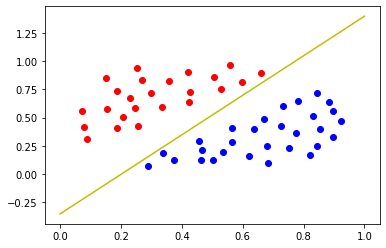

In [12]:
"testing the functions"
pointsClass1_labeled = np.hstack((pointsClass1, np.ones((pointsClass1.shape[0], 1))))
pointsClass2_labeled = np.hstack((pointsClass2, -np.ones((pointsClass2.shape[0], 1))))
training_set = np.vstack((pointsClass1_labeled, pointsClass2_labeled))

beta, beta0 = HingeLossSVC(np.ones((2,)), 0, training_set)
y_coefficient = -beta[0]/beta[1]
x_list = np.linspace(0, 1, 100)
y_list = x_list * y_coefficient + beta0

plt.plot(x_list, y_list, c="y")
plt.scatter(pointsClass1[:, 0], pointsClass1[:, 1], c='r')
plt.scatter(pointsClass2[:, 0], pointsClass2[:, 1], c='b')
plt.show()

## Question III (10pts): Robust PCA for video surveillance 

Principal Component Analysis (PCA) retains an approximation of an original dataset $X$ by focusing on the largest singular values. Such an order $K$ approximation can be obtained from the singular value decomposition $\boldsymbol U \boldsymbol \Sigma \boldsymbol V^T$ by truncating $\boldsymbol U$ to the first $K$ columns, retaining the $K\times K$ diagonal matrix $\boldsymbol \Sigma_k$ as well as the first $K$ rows of $\boldsymbol V^T$, $\boldsymbol V_k^T$, and writing the approximation as $\boldsymbol U_k \boldsymbol \Sigma_k \boldsymbol V^T_k$. This approach is particularly efficient when each of the feature vectors (or images in this case) are close to each other. When there are sharp variations across images, such as when an object appears, move throughout the images and then disapears, a simple PCA does not suffice anymore and one might want to extend it to something more robust. The escalator sequence below is an example of such sequence (the movie can be found on github). 

(20800,)


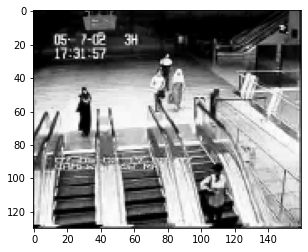

In [13]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# read video

import scipy.io
movie = scipy.io.loadmat('escalator_data.mat')
#frame0 = 
print(np.shape(movie['X'][:,0]))

plt.imshow(movie['X'][:,0].reshape((160,130)).swapaxes(0, 1), cmap='gray')
plt.show()

The idea of Robust PCA is to add a "sparse" component to the traditional PCA decomposition. Given a collection of images that we store as the columns of the matrix $X$, one then looks for a decomposition
 
\begin{align} 
\boldsymbol X = \boldsymbol Y + \boldsymbol S
\end{align}

Where $Y$ is a matrix which contains the original PCA decomposition, and thus encodes the part of the images that remains approximately constant throughout the sequence (background), and $\boldsymbol S$ is the sparse part (i.e a sequence of images that are varying through the sequence but only at a small number of pixel positions in the images (foreground), in other words most of the pixels in $S$ are assumed to be zero). To recover each part one approach is to proceed as follows, see [Candes et al.](https://arxiv.org/pdf/0912.3599.pdf)

We let $\mu$ to denote the parameter that controls the amount of dara we want to store in the sparse foreground extraction part, $\boldsymbol S$. A good choice is to take $\mu = n_1n_2/4\|\mathbf{X}\|_1$ where $\mathbf{X}\in\mathbb{R}^{n_1\times n_2}$ encodes the video surveillance sequence (each frame being stacked as a column of $\mathbf{X}$) and $\|\mathbf{X}\|_1$ denotes the entry wise $\ell_1$ norm of $\mathbf{X}$, $\mathbf{X} = \sum_{ij} |X_{ij}|$

The algorithm then proceeds as follows


__Initialize__ $Y$, $S$ to $0$

__Step 1.__ Compute the truncated SVD of the matrix $X - S - \mu^{-1}Y$, i.e. let $X - S - \mu^{-1}Y = U\Sigma V^T$. The truncated SVD is then obtained by replacing the diagonal matrix of singular values with the truncation 
$
\sigma \leftarrow \text{sign}(\sigma)\max(|\sigma| - \mu, 0)  
$

and store it in $L$, $L = SVD_{\mu}(X - S - \mu^{-1}Y)$ 



__Step 2.__ Apply the thresholding operator $f(x) = \text{sign}(x)\max(|x| - \lambda \mu, 0) $ with threshold $\lambda\mu$ to the entries of the matrix $X - L + \mu^{-1}Y$ and store the result in $\mathbf{S}$.

__Step 3.__ Update the matrix $Y$ as $Y \leftarrow Y + \mu(X - L - S)$


A good approach to initialize the parameters is to take $lambda = 1/\max(n_1,n_2)$ where $\max(n_1,n_2)$ is the max number of rows or columns of the data matrix. One can also terminate the algorithm when $\|X-L-S\|_F \leq  \delta \|X\|_F$ where $\|X\|_F$ is the Frobenius norm of the matrix and $\delta$ can be taken for example as $10^{-7}$. 


Additional indications: if computing the full SVD from linalg is too expensive, you can replace it with the fast randomized PCA from facebook (see [fbpca](https://fbpca.readthedocs.io/en/latest/)) or a sparse SVD.


### Question 3.1. (8pts) Complete the code below which separates the sparse part from the PCA decomposition

In [14]:
import numpy as np 
from __future__ import division
from scipy.sparse.linalg import svds
import fbpca



def robustPCA(X, delta=1.5e-8, mu=None, maxiter=500):
	"""
	The function should return a PCA like part stored in 'L' with only a few singular values
	that are non zero and a sparse sequence 'S' in which the images are black except w very
	limited number of pixels
	"""

	# Initialize the tuning parameters.
	lam = 1 / max(X.shape[0], X.shape[1])
	if mu is None:
		# complete with your value for mu
		mu = X.shape[0] * X.shape[1] / (4 * np.linalg.norm(X, ord=1, axis=None))

	# Convergence criterion.
	norm = np.sum(X ** 2)

	# Iterate.
	i = 0
	# rank = np.min(X.shape[0], X.shape[1])
	S = np.zeros((X.shape[0], X.shape[1]))
	Y = np.zeros((X.shape[0], X.shape[1]))
	while i < max(maxiter, 1):

		# Step 1. Compute and truncate the SVD
		step1_temp = X - S - (1/mu) * Y
		u, sigma_arrary, vt = fbpca.pca(step1_temp, raw=True, n_iter=5)
		truncated_sigma = np.sign(sigma_arrary) * np.maximum(np.abs(sigma_arrary)-mu, 0)
		truncated_sigma_matrix = np.zeros((u.shape[1], vt.shape[0]))
		for j in range(len(truncated_sigma)):
			truncated_sigma_matrix[j, j] = truncated_sigma[j]
		L = np.matmul(np.matmul(u, truncated_sigma_matrix), vt)

		# Step 2. Truncate the entries of X - L + mu^(-1)Y
		step2_temp = X - L + (1/mu) * Y
		S = np.sign(step2_temp) * np.maximum(np.abs(step2_temp) - lam*mu, 0)

		# Step 3. Update the matrix Y
		Y = Y + mu * (X - L - S)

		# Convergence criterion
		err = np.sqrt(np.sum((X-L-S) ** 2) / norm)

		print(err)
		if err < delta:
			break
		i += 1

	return L, S

### Question 3.2. (2pts) 

Apply your function to the escalator sequence and display the result on at least one frame. Use subplot to display the extracted background and its corresponding foreground side by side. 

In [20]:
# put your code here
L_result, S_result = robustPCA(movie["X"])

1.9000519756503515e-06
1.525802166248158e-08
1.4782354461585746e-08


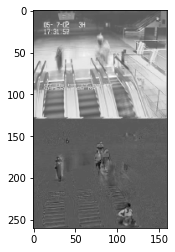

In [21]:
temp_image = np.hstack((L_result[:, 5].reshape(160, 130), S_result[:, 5].reshape(160, 130)))
plt.imshow(temp_image.swapaxes(0, 1), cmap='gray')
plt.show()